In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-04-13 12:16:41.183213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
# INITIALISE SOME IMPORTANT VARIABLES

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [60]:
# INIT DATASETS

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             shuffle=True,
                                                             batch_size=BATCH_SIZE,
                                                             image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                             shuffle=True,
                                                             batch_size=BATCH_SIZE,
                                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [61]:
print(train_dataset.class_names)

['cats', 'dogs']


2024-04-13 12:16:48.571686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-04-13 12:16:48.572363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


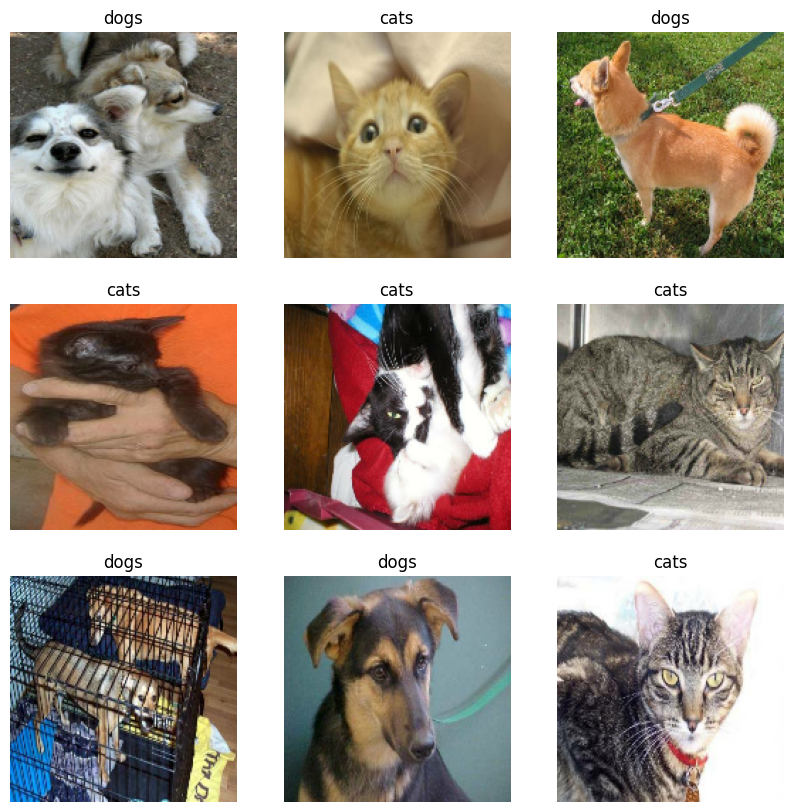

In [6]:
# SHOW SOME IMAGES

class_names = train_dataset.class_names

plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [7]:
# SPLIT VALIDATION INTO TWO : VALIDATION AND TEST

print(len(validation_dataset)) # 32 batches
# or
VAL_BATCHES = tf.data.experimental.cardinality(validation_dataset) # IN TENSOR
TEST_SIZE = VAL_BATCHES // 5
test_dataset = validation_dataset.take(TEST_SIZE)
validation_dataset = validation_dataset.skip(TEST_SIZE)

32


In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [9]:
# CONFIGURE THE PERFORMANCE

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# AUGMENTATION

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

2024-04-13 12:16:59.675576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-04-13 12:16:59.675951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


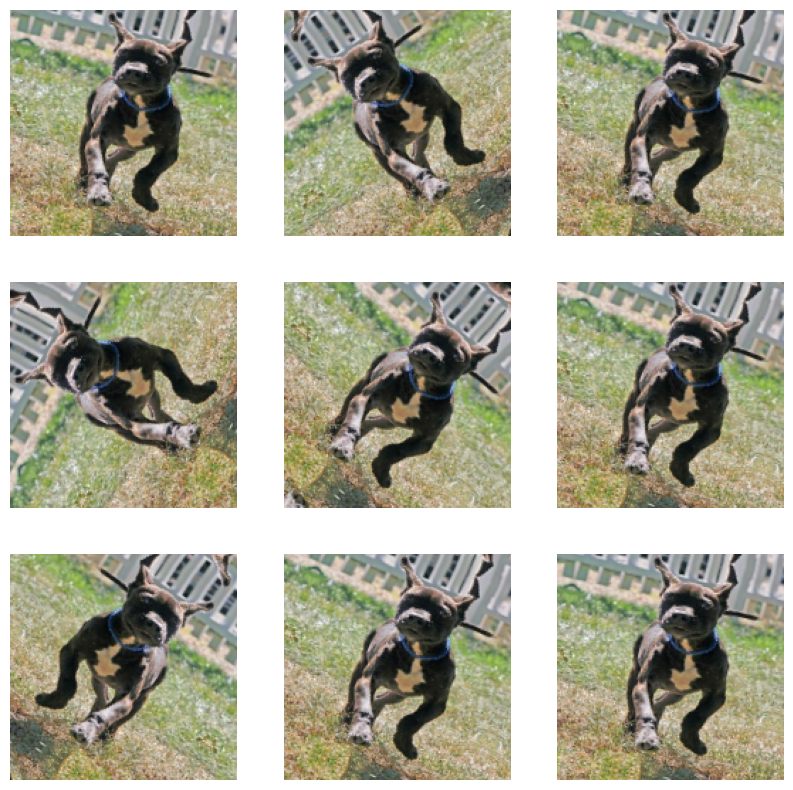

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

2024-04-13 12:17:06.917372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-04-13 12:17:06.917737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


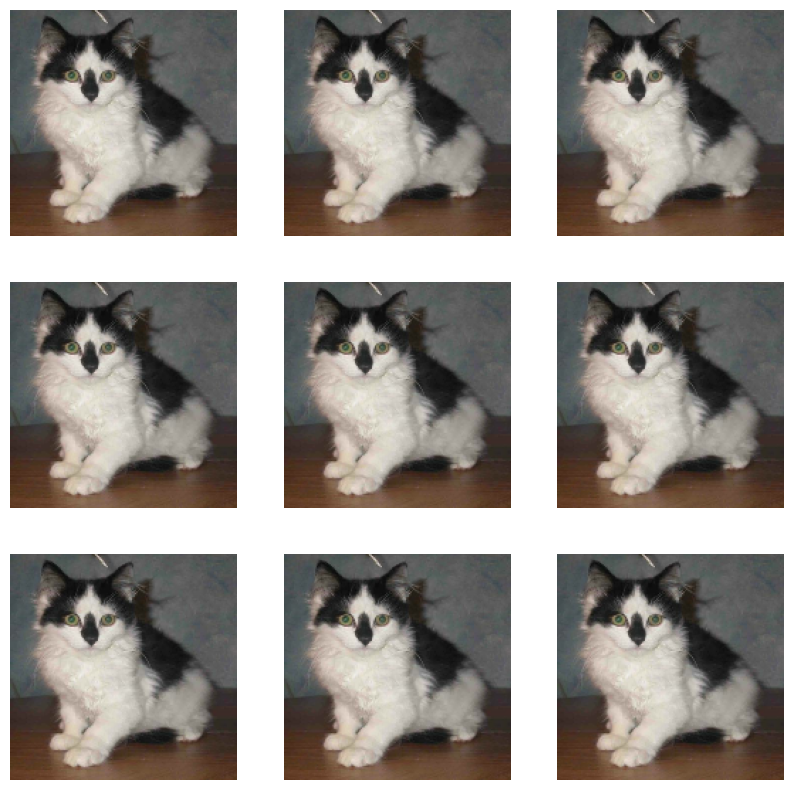

In [12]:
# PREPROCESS IMAGE WITH EXISTING METHOD

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./255)

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = rescale(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')




In [13]:
# INIT BASE MODEL
# ADD 3 channels to make it 3-dimensional
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# BASE IS USED FOR FEATURE EXTRACTION
# HEAD IS USED FOR CLASSIFICATION

2024-04-13 12:17:17.572184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-04-13 12:17:17.572520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


(32, 5, 5, 1280)


In [15]:
# FEATURE EXTRACTION

# FREEZE THE LAYERS TO PREVENT FROM TRAINING USING BACKWARD PROPAGATION
# BASE MODEL: MobileNetV2 has lots of layers and freezing will applied to all layers
"""When the trainable parameter of a BatchNormalization layer is set to False, it means that these running estimates are not updated during training.
Instead, the layer uses the mean and variance statistics computed from the training data (or a moving average of them) during inference to normalize the input data."""

base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [18]:
# CLASSIFICATION HEAD

# POOLING LAYER IS USED TO REDUCE WIDTH AND HEIGHT OF FEATURE MAPS WHILE RETAINING IMPORTANT FEATURE
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# GlobalAveragePooling2D results in a single value (scalar) for each channel, effectively reducing the spatial dimensions of the feature maps to 1x1.
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [20]:
print(IMG_SHAPE)

(160, 160, 3)


In [21]:
# BUILD A MODEL
# WAYS TO CREATE MODEL: SEQUENTIAL, FUNCTIONAL, SUBCLASSING, TRANSFER LEARNING

# USING FUNCTIONAL
inputs = tf.keras.Input(shape=IMG_SHAPE)
# APPLY AUGMENTATION
x = data_augmentation(inputs)
# USE PREPROCESS
x = preprocess_input(x)
# USE BASE
x = base_model(x, training=False)
# USE HEAD
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
len(model.trainable_variables)

2

In [25]:
# COMPILE

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2024-04-13 12:19:06.428837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2024-04-13 12:19:06.429200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]


26/26 [==============================] - 4s 104ms/step - loss: 0.6986 - accuracy: 0.5755


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.70
initial accuracy: 0.58


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 167ms/step - loss: 0.6335 - accuracy: 0.6455 - val_loss: 0.4731 - val_accuracy: 0.8106
Epoch 2/10
63/63 [==============================] - 11s 167ms/step - loss: 0.4755 - accuracy: 0.7865 - val_loss: 0.3570 - val_accuracy: 0.8861
Epoch 3/10
63/63 [==============================] - 10s 163ms/step - loss: 0.3749 - accuracy: 0.8540 - val_loss: 0.2881 - val_accuracy: 0.9183
Epoch 4/10
63/63 [==============================] - 10s 160ms/step - loss: 0.3480 - accuracy: 0.8645 - val_loss: 0.2389 - val_accuracy: 0.9319
Epoch 5/10
63/63 [==============================] - 10s 156ms/step - loss: 0.2964 - accuracy: 0.8830 - val_loss: 0.2059 - val_accuracy: 0.9443
Epoch 6/10
63/63 [==============================] - 11s 167ms/step - loss: 0.2789 - accuracy: 0.8935 - val_loss: 0.1808 - val_accuracy: 0.9468
Epoch 7/10
63/63 [==============================] - 12s 185ms/step - loss: 0.2400 - accuracy: 0.9105 - val_loss: 0.1568 - val_accuracy: 0.9592

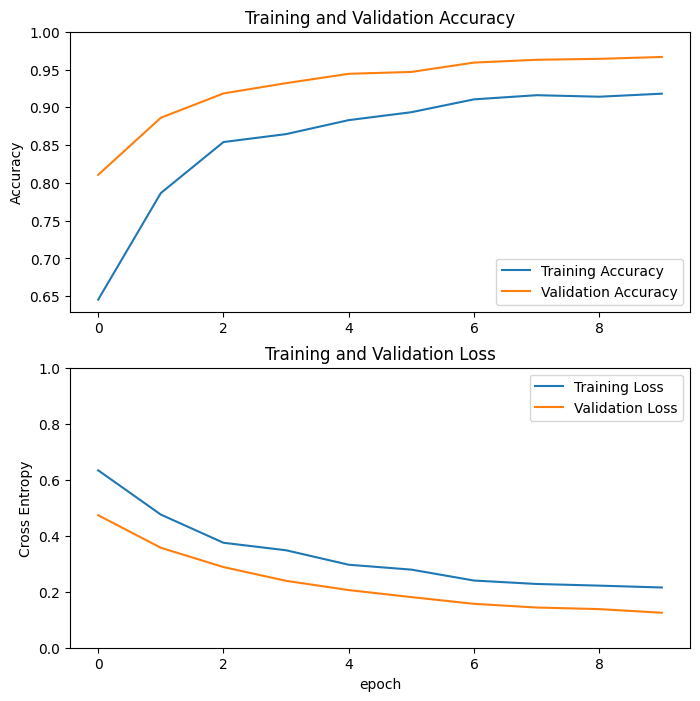

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
# UNFREEZE

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
len(model.trainable_variables)

56

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 18s 236ms/step - loss: 0.1432 - accuracy: 0.9475 - val_loss: 0.0665 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 14s 227ms/step - loss: 0.1148 - accuracy: 0.9520 - val_loss: 0.0618 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 14s 221ms/step - loss: 0.1016 - accuracy: 0.9620 - val_loss: 0.0582 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 16s 252ms/step - loss: 0.0895 - accuracy: 0.9610 - val_loss: 0.0469 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 14s 223ms/step - loss: 0.0960 - accuracy: 0.9625 - val_loss: 0.0584 - val_accuracy: 0.9765
Epoch 15/20
63/63 [==============================] - 15s 242ms/step - loss: 0.0908 - accuracy: 0.9650 - val_loss: 0.0500 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 16s 253ms/step - loss: 0.0712 - accuracy: 0.9710 - val_loss: 0.0439 - val_accuracy:

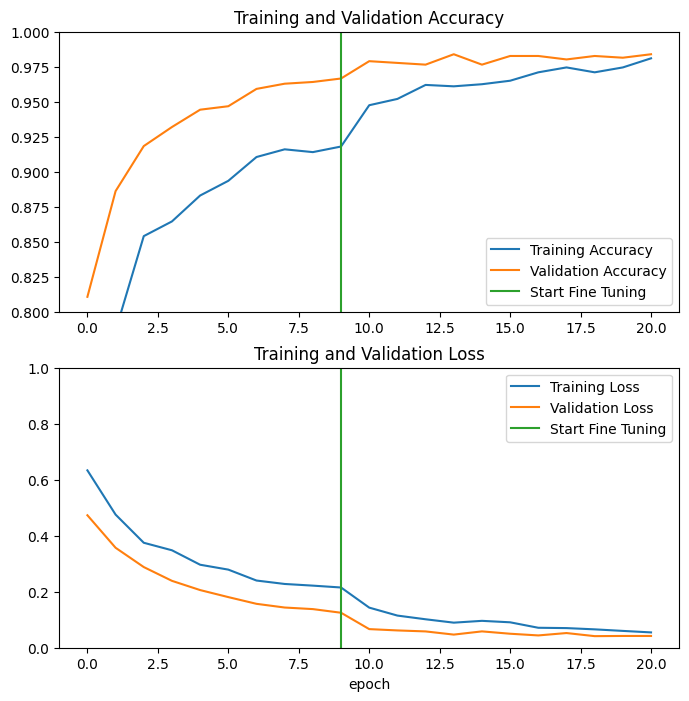

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2024-04-13 12:29:40.164497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2024-04-13 12:29:40.169521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]


6/6 [==============================] - 1s 115ms/step - loss: 0.0441 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


2024-04-13 12:34:43.299256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,160,160,3]
	 [[{{node Placeholder/_0}}]]


Predictions:
 [1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0]
Labels:
 [1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0]


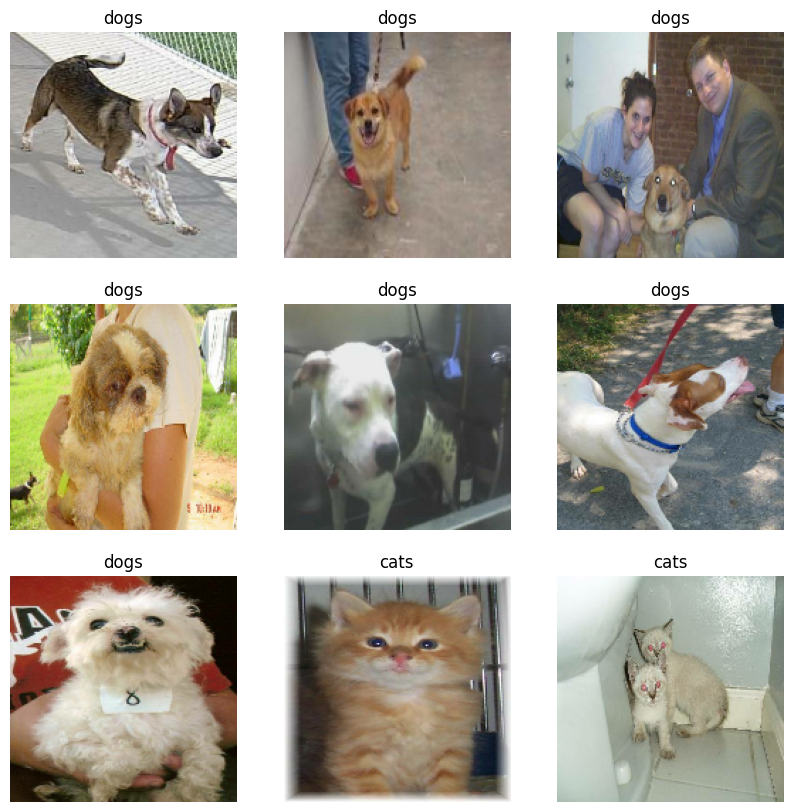

In [57]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.relu(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [58]:
# SAVE MODEL

model.save('cat_vs_dog.h5')

# LOAD 
# loaded_model = tf.keras.models.load_model('cat_vs_dog.h5')